# Autoencoding dataset

In more complex problems, the network architecture has to be deeper, as the relationships might be harder to model. There are some lessons to be learned while working on such examples, so this chapter will be an end-to-end implementation of the autoencoder applied for anomaly detection.

## Credit Card Fraud Detection

*The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.*

*It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.*

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [81]:
%matplotlib inline

import pandas as pd

transactions_df = pd.read_csv("./dataset/creditcardfraud/creditcard.zip", 
                              compression="zip")
transactions_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [82]:
transactions_df.groupby("Class").count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


## Scaling the dataset

For the purposes of neural networks, we typically perform some normalization. In this case we'll use a min-max strategy which by default scales all the value to a range \[0,1\].

In [83]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
transactions_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(transactions_df), 
                                      columns=transactions_df.columns)

In [71]:
X_nonfraud = transactions_scaled_df[0 == transactions_scaled_df["Class"]]\
    .drop("Class", axis=1)
X_fraud = transactions_scaled_df[1 == transactions_scaled_df["Class"]]\
    .drop("Class", axis=1)

X_nonfraud.shape, X_fraud.shape

((284315, 30), (492, 30))

## Defining network architecture

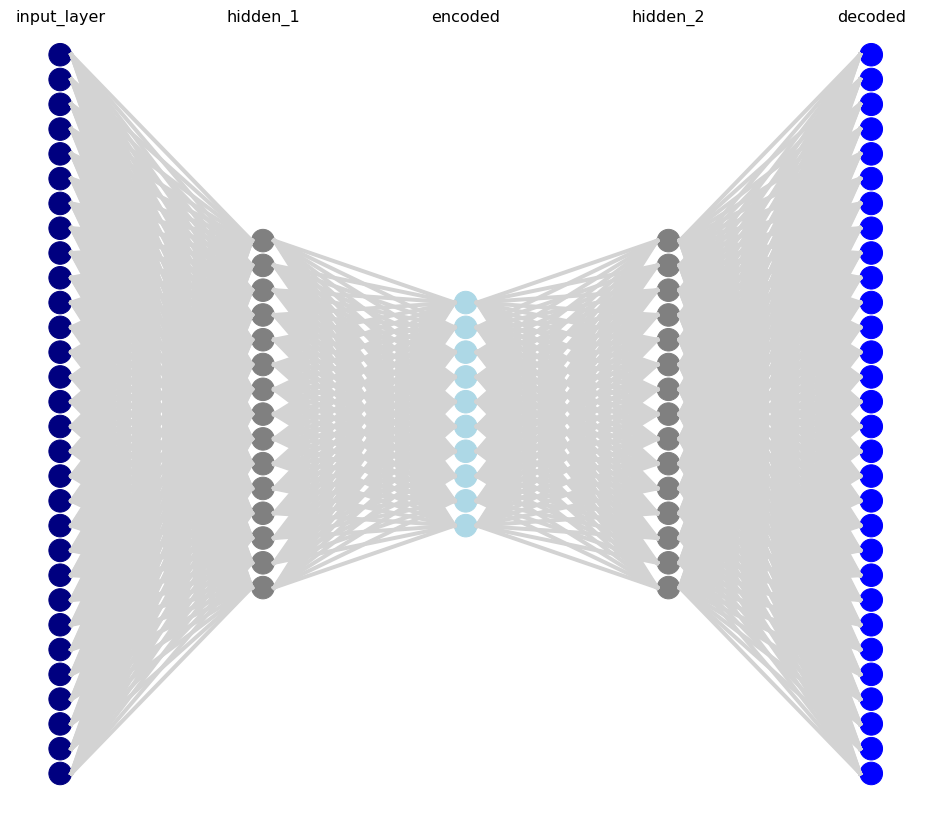

(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71c8978c18>)

In [90]:
import nnv
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 15)

layers = [
    {"title":"input_layer", "units": 30, "color": "navy"},
    {"title":"hidden_1", "units": 15},
    {"title":"encoded", "units": 10, "color": "lightBlue"},
    {"title":"hidden_2", "units": 15},
    {"title":"decoded", "units": 30, "color": "blue"},
]

nnv.NNV(layers, max_num_nodes_visible=30, 
        node_radius=5, spacing_layer=80, font_size=16)\
    .render()

In [91]:
from keras.layers import Input, Dense
from keras.models import Model

input_layer = Input(shape=(30, ))
hidden_1 = Dense(15, activation="tanh")(input_layer)
encoded = Dense(10, activation="tanh")(hidden_1)
hidden_2 = Dense(15, activation="tanh")(encoded)
decoded = Dense(30, activation="sigmoid")(hidden_2)
autoencoder = Model(input_layer, decoded)

In [92]:
autoencoder.compile(optimizer="adam", 
                    loss="mean_squared_error")

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_nonfraud, test_size=0.25, 
                                   random_state=2019)

In [94]:
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 213236 samples, validate on 71079 samples
Epoch 1/100
213236/213236 [==============================] - 3s 12us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 2/100
213236/213236 [==============================] - 2s 11us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/100
213236/213236 [==============================] - 3s 12us/step - loss: 8.4760e-04 - val_loss: 7.2760e-04
Epoch 4/100
213236/213236 [==============================] - 2s 9us/step - loss: 6.9569e-04 - val_loss: 5.7155e-04
Epoch 5/100
213236/213236 [==============================] - 2s 9us/step - loss: 4.9830e-04 - val_loss: 4.6953e-04
Epoch 6/100
213236/213236 [==============================] - 2s 11us/step - loss: 4.2356e-04 - val_loss: 3.7152e-04
Epoch 7/100
213236/213236 [==============================] - 2s 11us/step - loss: 3.6366e-04 - val_loss: 3.5754e-04
Epoch 8/100
213236/213236 [==============================] - 2s 10us/step - loss: 3.5382e-04 - val_loss: 3.5146e-04
Epoch 9/100
213236/213236 [============

Epoch 71/100
213236/213236 [==============================] - 3s 12us/step - loss: 2.1395e-04 - val_loss: 2.1354e-04
Epoch 72/100
213236/213236 [==============================] - 3s 12us/step - loss: 2.1365e-04 - val_loss: 2.1242e-04
Epoch 73/100
213236/213236 [==============================] - 2s 11us/step - loss: 2.1339e-04 - val_loss: 2.1323e-04
Epoch 74/100
213236/213236 [==============================] - 2s 11us/step - loss: 2.1326e-04 - val_loss: 2.1132e-04
Epoch 75/100
213236/213236 [==============================] - 2s 11us/step - loss: 2.1305e-04 - val_loss: 2.1121e-04
Epoch 76/100
213236/213236 [==============================] - 2s 12us/step - loss: 2.1280e-04 - val_loss: 2.1268e-04
Epoch 77/100
213236/213236 [==============================] - 2s 11us/step - loss: 2.1264e-04 - val_loss: 2.1244e-04
Epoch 78/100
213236/213236 [==============================] - 2s 11us/step - loss: 2.1247e-04 - val_loss: 2.1207e-04
Epoch 79/100
213236/213236 [==============================] - 2s

## Loss function values comparison

As said, the value of the loss function is an indicator of how well our autoencoder was able to recreate given input. We can easily check how the values differ between train, test and fraud datasets.

In [115]:
from keras.losses import mean_squared_error
from keras import backend as K

mse_train = K.eval(mean_squared_error(X_train, 
                                      autoencoder.predict(X_train)))
mse_train_df = pd.DataFrame.from_dict({"mse": mse})
mse_train_df.describe()

,mse
count,71079.000000
mean,0.000209
std,0.000479
min,0.000008
25%,0.000074
50%,0.000123
75%,0.000206
max,0.025812


In [116]:
mse_test = K.eval(mean_squared_error(X_test, 
                                     autoencoder.predict(X_test)))
mse_test_df = pd.DataFrame.from_dict({"mse": mse})
mse_test_df.describe()

,mse
count,71079.000000
mean,0.000209
std,0.000479
min,0.000008
25%,0.000074
50%,0.000123
75%,0.000206
max,0.025812


In [117]:
mse_fraud = K.eval(mean_squared_error(X_fraud, 
                                      autoencoder.predict(X_fraud)))
mse_fraud_df = pd.DataFrame.from_dict({"mse": mse_fraud})
mse_fraud_df.describe()

,mse
count,492.000000
mean,0.008193
std,0.009326
min,0.000031
25%,0.003017
50%,0.004788
75%,0.008167
max,0.065176


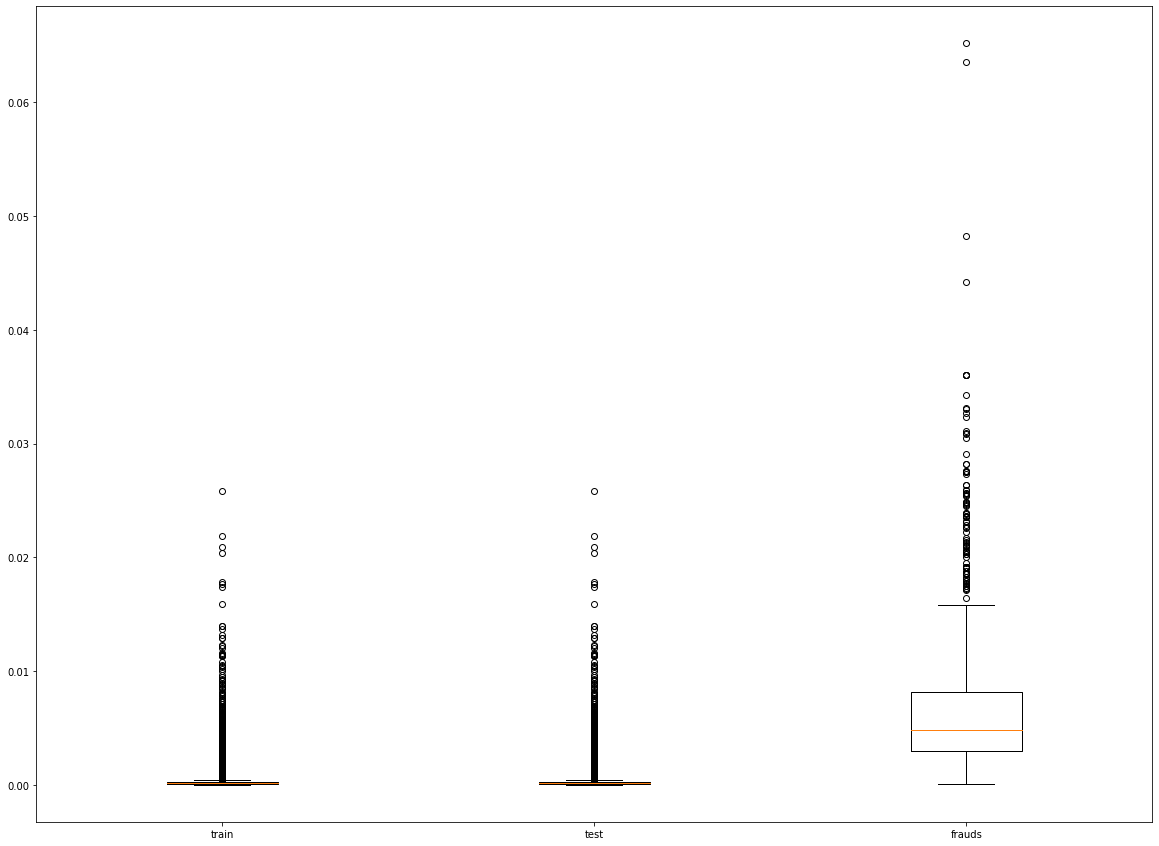

In [118]:
plt.boxplot([mse_train_df["mse"], mse_test_df["mse"], 
             mse_fraud_df["mse"]], 
            labels=["train", "test", "frauds"])
plt.show()